In [1]:
!pip install -q arxiv
!pip install -q pymupdf
!pip install -q sentence-transformers
!pip install -q faiss-cpu
!pip install -q evaluate
!pip install -q datasets
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q trl
!pip install -q einops
!pip install -q langchain
!pip install -q langchain-community
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 84.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:

In [2]:
import os
import re
import arxiv
import fitz  
import faiss
import numpy as np
from datasets import Dataset
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

2025-09-15 08:00:11.070855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757923211.271014      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757923211.334696      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# data collection
def get_cvpr_papers(max_results=10):
    search = arxiv.Search(
        query="cat:cs.CV",
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )
    papers = []
    for result in search.results():
        papers.append({
            "title": result.title,
            "authors": result.authors,  
            "summary": result.summary,
            "published": result.published,
            "updated": result.updated,
            "links": result.links, 
            "entry_id": result.entry_id,
            "primary_category": result.primary_category,
            "categories": result.categories,
            "comment": result.comment,
            "journal_ref": result.journal_ref,
            "doi": result.doi,
            "pdf_url": result.pdf_url
        })
    return papers

def download_and_extract_text(papers):
    
    for paper in papers:
        try:
            client = arxiv.Client()
            paper_obj = next(client.results(arxiv.Search(id_list=[paper['pdf_url'].split('/')[-1]])))
            pdf_path = paper_obj.download_pdf()
            doc = fitz.open(pdf_path)
            full_text = ""
            for page in doc:
                full_text += page.get_text()
            paper['full_text'] = full_text
        except Exception as e:
            print(f"Failed to process {paper['title']}: {e}")
            paper['full_text'] = ""
    return papers

# preprocessing
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'-\n', '', text)    
    text = text.strip()
    return text

def preprocess_papers(papers):
    for paper in papers:
        paper['full_text'] = clean_text(paper['full_text'])
    with open("/kaggle/working/papers_list.txt", "w", encoding="utf-8") as f:
        for paper in papers:
            f.write(f"Title: {paper['title']}\n")
            f.write(f"Authors: {', '.join([author.name for author in paper['authors']])}\n")
            f.write(f"Summary: {paper['summary']}\n")
            f.write(f"Published: {paper['published']}\n")
            f.write(f"Updated: {paper['updated']}\n")
            f.write(f"Links: {[link.href for link in paper['links']]}\n")
            f.write(f"Entry ID: {paper['entry_id']}\n")
            f.write(f"Primary Category: {paper['primary_category']}\n")
            f.write(f"Categories: {', '.join(paper['categories'])}\n")
            f.write(f"Comment: {paper['comment']}\n")
            f.write(f"Journal Ref: {paper['journal_ref']}\n")
            f.write(f"DOI: {paper['doi']}\n")
            f.write(f"PDF URL: {paper['pdf_url']}\n")
            f.write(f"Cleaned Text Preview: {paper['full_text'][:500]}...\n")  # store first 500 chars
            f.write("="*80 + "\n")
    return papers

# vector store creation
def create_vector_store(papers, model_name="all-MiniLM-L6-v2"):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = []
    for paper in papers:
        if paper['full_text']:
            chunks = text_splitter.split_text(paper['full_text'])
            for chunk in chunks:
                docs.append({
                    "content": chunk,
                    "metadata": {
                        "title": paper["title"],
                        "authors": ", ".join([author.name for author in paper["authors"]]),
                        "summary": paper["summary"],
                        "published": str(paper["published"]),
                        "updated": str(paper["updated"]),
                        "links": ", ".join([str(link) for link in paper["links"]]),
                        "entry_id": paper["entry_id"],
                        "primary_category": paper["primary_category"],
                        "categories": ", ".join(paper["categories"]),
                        "comment": paper["comment"] if paper["comment"] else "",
                        "journal_ref": paper["journal_ref"] if paper["journal_ref"] else "",
                        "doi": paper["doi"] if paper["doi"] else "",
                        "pdf_url": paper["pdf_url"]
                    }
                })

    # Use LangChain's document structure
    from langchain.docstore.document import Document
    langchain_docs = [Document(page_content=doc['content'], metadata=doc['metadata']) for doc in docs]

    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    vector_store = FAISS.from_documents(langchain_docs, embeddings)
    return vector_store


if __name__ == '__main__':
    # Fetch and process papers
    cvpr_papers = get_cvpr_papers(max_results=10) 
    cvpr_papers_with_text = download_and_extract_text(cvpr_papers)
    preprocessed_papers = preprocess_papers(cvpr_papers_with_text)

    # Create and save the vector store
    vector_store = create_vector_store(preprocessed_papers)
    vector_store.save_local("faiss_index_cvpr")

    print("Vector store created successfully.")

/tmp/ipykernel_36/2959583630.py:9: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Vector store created successfully.


In [8]:
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import pandas as pd
import os

# disable wandb_api
os.environ["WANDB_DISABLED"] = "true"

# Dataset Preparation (Synthetic Q&A) 
def create_synthetic_dataset(papers):
    prompts = []
    for paper in papers:
        # Handle authors and links gracefully
        authors_str = ", ".join([author.name for author in paper["authors"]])
        links_str = ", ".join([link.href for link in paper["links"]])
        if paper["summary"]:
            prompts.append(f"### Question: What is the methodology proposed in the paper titled '{paper['title']}'?\n### Answer: {paper['summary']}")
            prompts.append(f"### Question: What are the main contributions of '{paper['title']}'?\n### Answer: {paper['summary']}")
        # Author info
        prompts.append(f"### Question: Who are the authors of '{paper['title']}'?\n### Answer: {authors_str}")
        # Metadata questions
        prompts.append(f"### Question: When was the paper '{paper['title']}' first published?\n### Answer: {paper['published']}")
        prompts.append(f"### Question: When was the paper '{paper['title']}' last updated?\n### Answer: {paper['updated']}")
        prompts.append(f"### Question: What is the primary category of '{paper['title']}'?\n### Answer: {paper['primary_category']}")
        prompts.append(f"### Question: What categories is the paper '{paper['title']}' cross-listed in?\n### Answer: {', '.join(paper['categories'])}")
        prompts.append(f"### Question: Does the paper '{paper['title']}' include any comments?\n### Answer: {paper['comment']}")
        prompts.append(f"### Question: What is the journal reference for '{paper['title']}'?\n### Answer: {paper['journal_ref']}")
        prompts.append(f"### Question: What is the DOI for '{paper['title']}'?\n### Answer: {paper['doi']}")
        prompts.append(f"### Question: Where can I download the PDF of '{paper['title']}'?\n### Answer: {paper['pdf_url']}")
        prompts.append(f"### Question: What links are available for '{paper['title']}'?\n### Answer: {links_str}")
        prompts.append(f"### Question: What is the entry ID (abstract URL) for '{paper['title']}'?\n### Answer: {paper['entry_id']}")

        # Optional: include full text preview (helps model overfit on paper content)
        if paper["full_text"]:
            preview_text = paper["full_text"][:500]
            prompts.append(f"### Question: Provide a brief preview of the paper '{paper['title']}'.\n### Answer: {preview_text}")

    return Dataset.from_dict({"text": prompts})

# model configuration
model_id = "Qwen/Qwen3-4B-Instruct-2507"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# fine tuning with transformers.Trainer
if __name__ == '__main__':
    synthetic_dataset = create_synthetic_dataset(preprocessed_papers)

    tokenized_dataset = synthetic_dataset.map(
        lambda examples: tokenizer(examples["text"], truncation=True, max_length=1024, padding=False),
        batched=True
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    model.config.use_cache = False
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

    training_args = TrainingArguments(
        output_dir="./qwen3-4b-finetuned",
        num_train_epochs=10,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        logging_dir="./logs",
        logging_steps=10,
        learning_rate=1e-4,
        save_strategy="epoch",
        fp16=True,
        report_to="none",
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Start the training process
    trainer.train()

    # Save the fine-tuned model adapters
    trainer.save_model("./qwen3-4b-finetuned")
    tokenizer.save_pretrained("./qwen3-4b-finetuned")
    print("\nFine-tuning complete and model adapters saved successfully.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

/tmp/ipykernel_36/1320431459.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,2.591700
20,2.018400
30,1.368000
40,0.911700
50,1.123400
60,0.687600
70,0.615000
80,0.461000
90,0.465100
100,0.446700


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/


Fine-tuning complete and model adapters saved successfully.


In [9]:
# merge fine tuned adapters with base model
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os

# configuration
base_model_id = "Qwen/Qwen3-4B-Instruct-2507"
adapter_path = "./qwen3-4b-finetuned"
merged_model_path = "./qwen3-4b-cvpr-merged" 

print("Loading base model...")
# Load the base model with the same precision as used for training
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)

print("Loading PEFT adapters...")
# Load the PEFT model (base model + adapters)
model = PeftModel.from_pretrained(base_model, adapter_path)

print("Merging model and adapters...")
# Merge the adapters into the base model
model = model.merge_and_unload()
print("Merge complete.")

print(f"Saving merged model to {merged_model_path}...")
# Save the merged model and its tokenizer
model.save_pretrained(merged_model_path)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.save_pretrained(merged_model_path)

print("\nModel merged and saved successfully!")
print(f"You can now download the '{merged_model_path}' directory and use it with Ollama.")

# List files to confirm
print("\nFiles in the new merged model directory:")
for dirname, _, filenames in os.walk(merged_model_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

`torch_dtype` is deprecated! Use `dtype` instead!


Loading base model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading PEFT adapters...
Merging model and adapters...
Merge complete.
Saving merged model to ./qwen3-4b-cvpr-merged...

Model merged and saved successfully!
You can now download the './qwen3-4b-cvpr-merged' directory and use it with Ollama.

Files in the new merged model directory:
./qwen3-4b-cvpr-merged/vocab.json
./qwen3-4b-cvpr-merged/generation_config.json
./qwen3-4b-cvpr-merged/model-00001-of-00002.safetensors
./qwen3-4b-cvpr-merged/model-00002-of-00002.safetensors
./qwen3-4b-cvpr-merged/merges.txt
./qwen3-4b-cvpr-merged/added_tokens.json
./qwen3-4b-cvpr-merged/tokenizer_config.json
./qwen3-4b-cvpr-merged/special_tokens_map.json
./qwen3-4b-cvpr-merged/config.json
./qwen3-4b-cvpr-merged/model.safetensors.index.json
./qwen3-4b-cvpr-merged/chat_template.jinja
./qwen3-4b-cvpr-merged/tokenizer.json


In [11]:
# RAG pipeline with local model in Kaggle
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

print("Loading RAG components with a local model...")

# Load FAISS vector score
embeddings_model_name = "all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)
faiss_index_path = "/kaggle/working/faiss_index_cvpr"
vector_store = FAISS.load_local(
    faiss_index_path,
    embeddings,
    allow_dangerous_deserialization=True
)
print(f"FAISS index loaded successfully from: {faiss_index_path}")

# Load local fine tuned model and tokenizer
local_model_path = "/kaggle/working/qwen3-4b-cvpr-merged"
print(f"Loading tokenizer from: {local_model_path}")
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
print(f"Loading model from: {local_model_path}")
model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
print("Model loaded successfully onto the GPU.")

# Transformers pipeline for text generation
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.1,
    top_p=0.95
)
local_llm = HuggingFacePipeline(pipeline=pipe)
print("LangChain LLM wrapper created successfully.")

prompt_template = """Context: {context}

Question: {question}

Answer:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

# create RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=local_llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
print("RAG chain created successfully with simplified prompt.")

# Querying the RAG pipeline
if __name__ == '__main__':
    query = "What is the name of the new benchmark for measuring epistemic humility in MLLMs?"
    print(f"\nTesting RAG chain with query: '{query}'")
    try:
        result = qa_chain({"query": query})
        print("\n--- Test RAG Response ---")
        print(result['result'])
    except Exception as e:
        print(f"\nAn error occurred while querying the RAG chain: {e}")

Loading RAG components with a local model...
FAISS index loaded successfully from: /kaggle/working/faiss_index_cvpr
Loading tokenizer from: /kaggle/working/qwen3-4b-cvpr-merged
Loading model from: /kaggle/working/qwen3-4b-cvpr-merged


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:1


Model loaded successfully onto the GPU.
LangChain LLM wrapper created successfully.
RAG chain created successfully with simplified prompt.

Testing RAG chain with query: 'What is the name of the new benchmark for measuring epistemic humility in MLLMs?'


/tmp/ipykernel_36/3557732259.py:69: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": query})



--- Test RAG Response ---
Context: The central objective is identifying thresholds that enable the model to confidently accept reliable predictions while deferring uncertain cases, enhancing overall system safety and clinical trust. For entropy-based rejection, thresholds are calibrated using the distribution of entropy values computed from correctly classified samples in the training set. For interval-based rejection, the same quantile-based strategy is applied to the distribution of calibrated confidence margins, that is, the distance between the predicted class probability and the decision boundary (e.g., 0.5). In both cases, we explore a range of candidate percentiles (e.g., 75% to 95%) and, for each pathology, compute either a class-specific or global threshold corresponding to the selected quantile. This ensures that thresholds reflect uncertainty levels where the model has historically been accurate. We evaluate each candidate to select the optimal percentile by plotting the re

In [13]:
# Agent initialization with local RAG LLM in Kaggle
from langchain.agents import initialize_agent, Tool, AgentType

print("Initializing agent with the local RAG LLM...")

# Wrap the RAG chain to handle empty retrieval and generate Final Answer
def rag_final_answer(query: str) -> str:
    result = qa_chain({"query": query})
    if not result['result']:
        return "Final Answer: No relevant documents found."
    return f"Final Answer: {result['result']}"

# Define tools for the agent
tools = [
    Tool(
        name="CVPR Research Paper QA System",
        func=rag_final_answer,  # the wrapped RAG chain function
        description=(
            "Use this tool to answer specific questions about computer vision research papers from CVPR. "
            "The input must be a complete, well-formed question."
        )
    )
]

# Initialize agent with max_iterations=2
agent = initialize_agent(
    tools,
    local_llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,  # shows agent reasoning
    handle_parsing_errors=True,  
)
print("Agent initialized successfully.")

# Execute agent
if __name__ == '__main__':
    agent_query = (
        "Find a paper on generative models and explain its core methodology based on the provided context."
    )
    print(f"\nExecuting agent with query: '{agent_query}'")
    try:
        response = agent.run(agent_query)
        print("\n--- Agent's Final Answer ---")
        print(response)
    except Exception as e:
        print(f"\nAn error occurred while running the agent: {e}")


Initializing agent with the local RAG LLM...
Agent initialized successfully.

Executing agent with query: 'Find a paper on generative models and explain its core methodology based on the provided context.'


> Entering new AgentExecutor chain...
Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

CVPR Research Paper QA System(query: str) -> str - Use this tool to answer specific questions about computer vision research papers from CVPR. The input must be a complete, well-formed question.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [CVPR Research Paper QA System]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer:

In [14]:
# Evaluation Metrics

import pandas as pd
from evaluate import load
from sentence_transformers import SentenceTransformer, util
import numpy as np

print("Starting RAG pipeline evaluation with the simplified prompt...")

# a small but accurate evaluation dataset is created through preprocessed papers
eval_dataset = [
    {
        "question": "What is the name of the proposed framework for multimodal semantic segmentation and what model does it adapt?",
        "ground_truth_answer": "The paper presents MM SAM-adapter, a framework that extends the capabilities of the Segment Anything Model (SAM) for multimodal semantic segmentation.",
        "ground_truth_context_substring": "In this work, we present MM SAM-adapter, a novel framework that extends the capabilities of the Segment Anything Model (SAM) for multimodal semantic segmentation."
    },
    {
        "question": "What is the name of the training-free framework proposed for VLN-CE and what is its core idea?",
        "ground_truth_answer": "The paper proposes Graph-Constraints for Vision-and-Language Navigation (GC-VLN), a training-free framework for Vision-and-Language Navigation in Continuous Environments (VLN-CE).",
        "ground_truth_context_substring": "In this paper, we propose Graph-Constraints for Vision-and-Language Navigation (GC-VLN), a training-free framework for VLN-CE."
    },
    {
        "question": "What training paradigm does the study leverage to reduce the resource requirements of neural networks for image compression?",
        "ground_truth_answer": "The study leverages knowledge distillation, a training paradigm where smaller neural networks are trained on the outputs of larger, more complex models to improve performance.",
        "ground_truth_context_substring": "This study aims to reduce the resource requirements of neural networks used for image compression by leveraging knowledge distillation"
    },
    {
        "question": "What was the performance of the SSL-TOPC model compared to supervised learning in the Alzheimer's prediction study?",
        "ground_truth_answer": "The SSL model using temporal order prediction and contrastive learning (SSL-TOPC) outperformed supervised learning on six out of the seven downstream tasks.",
        "ground_truth_context_substring": "Importantly, our SSL model implemented with temporal order prediction and contrastive learning outperforms supervised learning on six out of seven downstream tasks."
    },
    {
        "question": "What are the two selective prediction mechanisms used to enhance the DenseNet-121 backbone in the chest X-ray diagnosis framework?",
        "ground_truth_answer": "The framework enhances a DenseNet-121 backbone with two selective prediction mechanisms: entropy-based rejection and confidence interval-based rejection.",
        "ground_truth_context_substring": "DenseNet-121 backbone, enhanced with two selective prediction mechanisms: entropy-based rejection and confidence interval-based rejection."
    },
    {
        "question": "How is 'visual grounding' defined in the context of vision-language models?",
        "ground_truth_answer": "Visual grounding is defined as the ability of a model to identify a region within a visual input that corresponds to a given textual description.",
        "ground_truth_context_substring": "Visual grounding refers to the ability of a model to identify a region within some visual input that matches a textual description."
    },
    {
        "question": "What is the main purpose of Compressed Video Quality Enhancement (CVQE)?",
        "ground_truth_answer": "Compressed video quality enhancement (CVQE) is essential for improving the user experience with lossy video codecs like H.264/AVC, H.265/HEVC, and H.266/VVC.",
        "ground_truth_context_substring": "Compressed video quality enhancement (CVQE) is crucial for improving user experience with lossy video codecs like H.264/AVC, H.265/HEVC, and H.266/VVC."
    }
]

print(f"Evaluation dataset created with {len(eval_dataset)} examples.")

results = []
retriever = vector_store.as_retriever(search_kwargs={'k': 5})

for item in eval_dataset:
    question = item["question"]
    ground_truth_context_sub = item["ground_truth_context_substring"]
    retrieved_docs = retriever.get_relevant_documents(question)
    retrieved_contexts = [doc.page_content for doc in retrieved_docs]
    hit = any(ground_truth_context_sub.lower() in ctx.lower() for ctx in retrieved_contexts)
    rr = 0.0
    for i, ctx in enumerate(retrieved_contexts):
        if ground_truth_context_sub.lower() in ctx.lower():
            rr = 1 / (i + 1)
            break
    response = qa_chain({"query": question})
    generated_answer = response['result']
    results.append({
        "question": question,
        "generated_answer": generated_answer,
        "retrieved_contexts": retrieved_contexts,
        "hit": hit,
        "rr": rr
    })

results_df = pd.DataFrame(results)
print("Evaluation loop complete.")

# calculate and report metrics
print("\n--- Evaluation Results ---")

hit_rate = results_df['hit'].mean()
mrr = results_df['rr'].mean()

print(f"\n--- Retriever Performance ---")
print(f"Hit Rate (Top 5): {hit_rate:.2%}")
print("  => What percentage of the time was the correct context found in the top 5 retrieved documents?")
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print("  => On average, how high up was the correct document in the retrieved list? (Closer to 1 is better)")
rouge = load('rouge')
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
ground_truth_answers = [item["ground_truth_answer"] for item in eval_dataset]
generated_answers = results_df['generated_answer'].tolist()
rouge_scores = rouge.compute(predictions=generated_answers, references=ground_truth_answers)
gt_embeddings = semantic_model.encode(ground_truth_answers, convert_to_tensor=True)
gen_embeddings = semantic_model.encode(generated_answers, convert_to_tensor=True)
cosine_scores = util.cos_sim(gt_embeddings, gen_embeddings)
mean_semantic_similarity = np.diag(cosine_scores.cpu()).mean()

print(f"\n--- Generator Performance ---")
print(f"ROUGE-L Score: {rouge_scores['rougeL']:.4f}")
print("  => Measures the longest common subsequence between generated and ground truth answers (word overlap).")
print(f"Mean Semantic Similarity: {mean_semantic_similarity:.4f}")
print("  => Measures if the *meaning* of the generated answer is close to the ground truth (closer to 1 is better).")
print("\n--- Detailed Per-Question Results ---")
for index, row in results_df.iterrows():
    print(f"\nQuestion: {row['question']}")
    print(f"  Ground Truth: {ground_truth_answers[index]}")
    print(f"  Generated: {row['generated_answer']}")
    print(f"  Context Hit: {'Yes' if row['hit'] else 'No'}")
    print(f"  Reciprocal Rank: {row['rr']:.2f}")

Starting RAG pipeline evaluation with the simplified prompt...
Evaluation dataset created with 7 examples.


/tmp/ipykernel_36/450827130.py:57: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(question)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Evaluation loop complete.

--- Evaluation Results ---

--- Retriever Performance ---
Hit Rate (Top 5): 85.71%
  => What percentage of the time was the correct context found in the top 5 retrieved documents?
Mean Reciprocal Rank (MRR): 0.6714
  => On average, how high up was the correct document in the retrieved list? (Closer to 1 is better)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


--- Generator Performance ---
ROUGE-L Score: 0.0485
  => Measures the longest common subsequence between generated and ground truth answers (word overlap).
Mean Semantic Similarity: 0.6331
  => Measures if the *meaning* of the generated answer is close to the ground truth (closer to 1 is better).

--- Detailed Per-Question Results ---

Question: What is the name of the proposed framework for multimodal semantic segmentation and what model does it adapt?
  Ground Truth: The paper presents MM SAM-adapter, a framework that extends the capabilities of the Segment Anything Model (SAM) for multimodal semantic segmentation.
  Generated: Context: [26, 35, 51]. In particu- lar, the Segment Anything Model (SAM) [26] is de- signed for prompt-guided instance segmentation, i.e., it can segment objects and their parts in RGB images using prompts such as points, bounding boxes, and masks. Our work aims to rely on SAM’s foundational knowledge to pursue semantic segmentation from multiple modalities. 

Building collaboration graph (authors + categories)...
Graph created with 49 nodes and 162 edges.


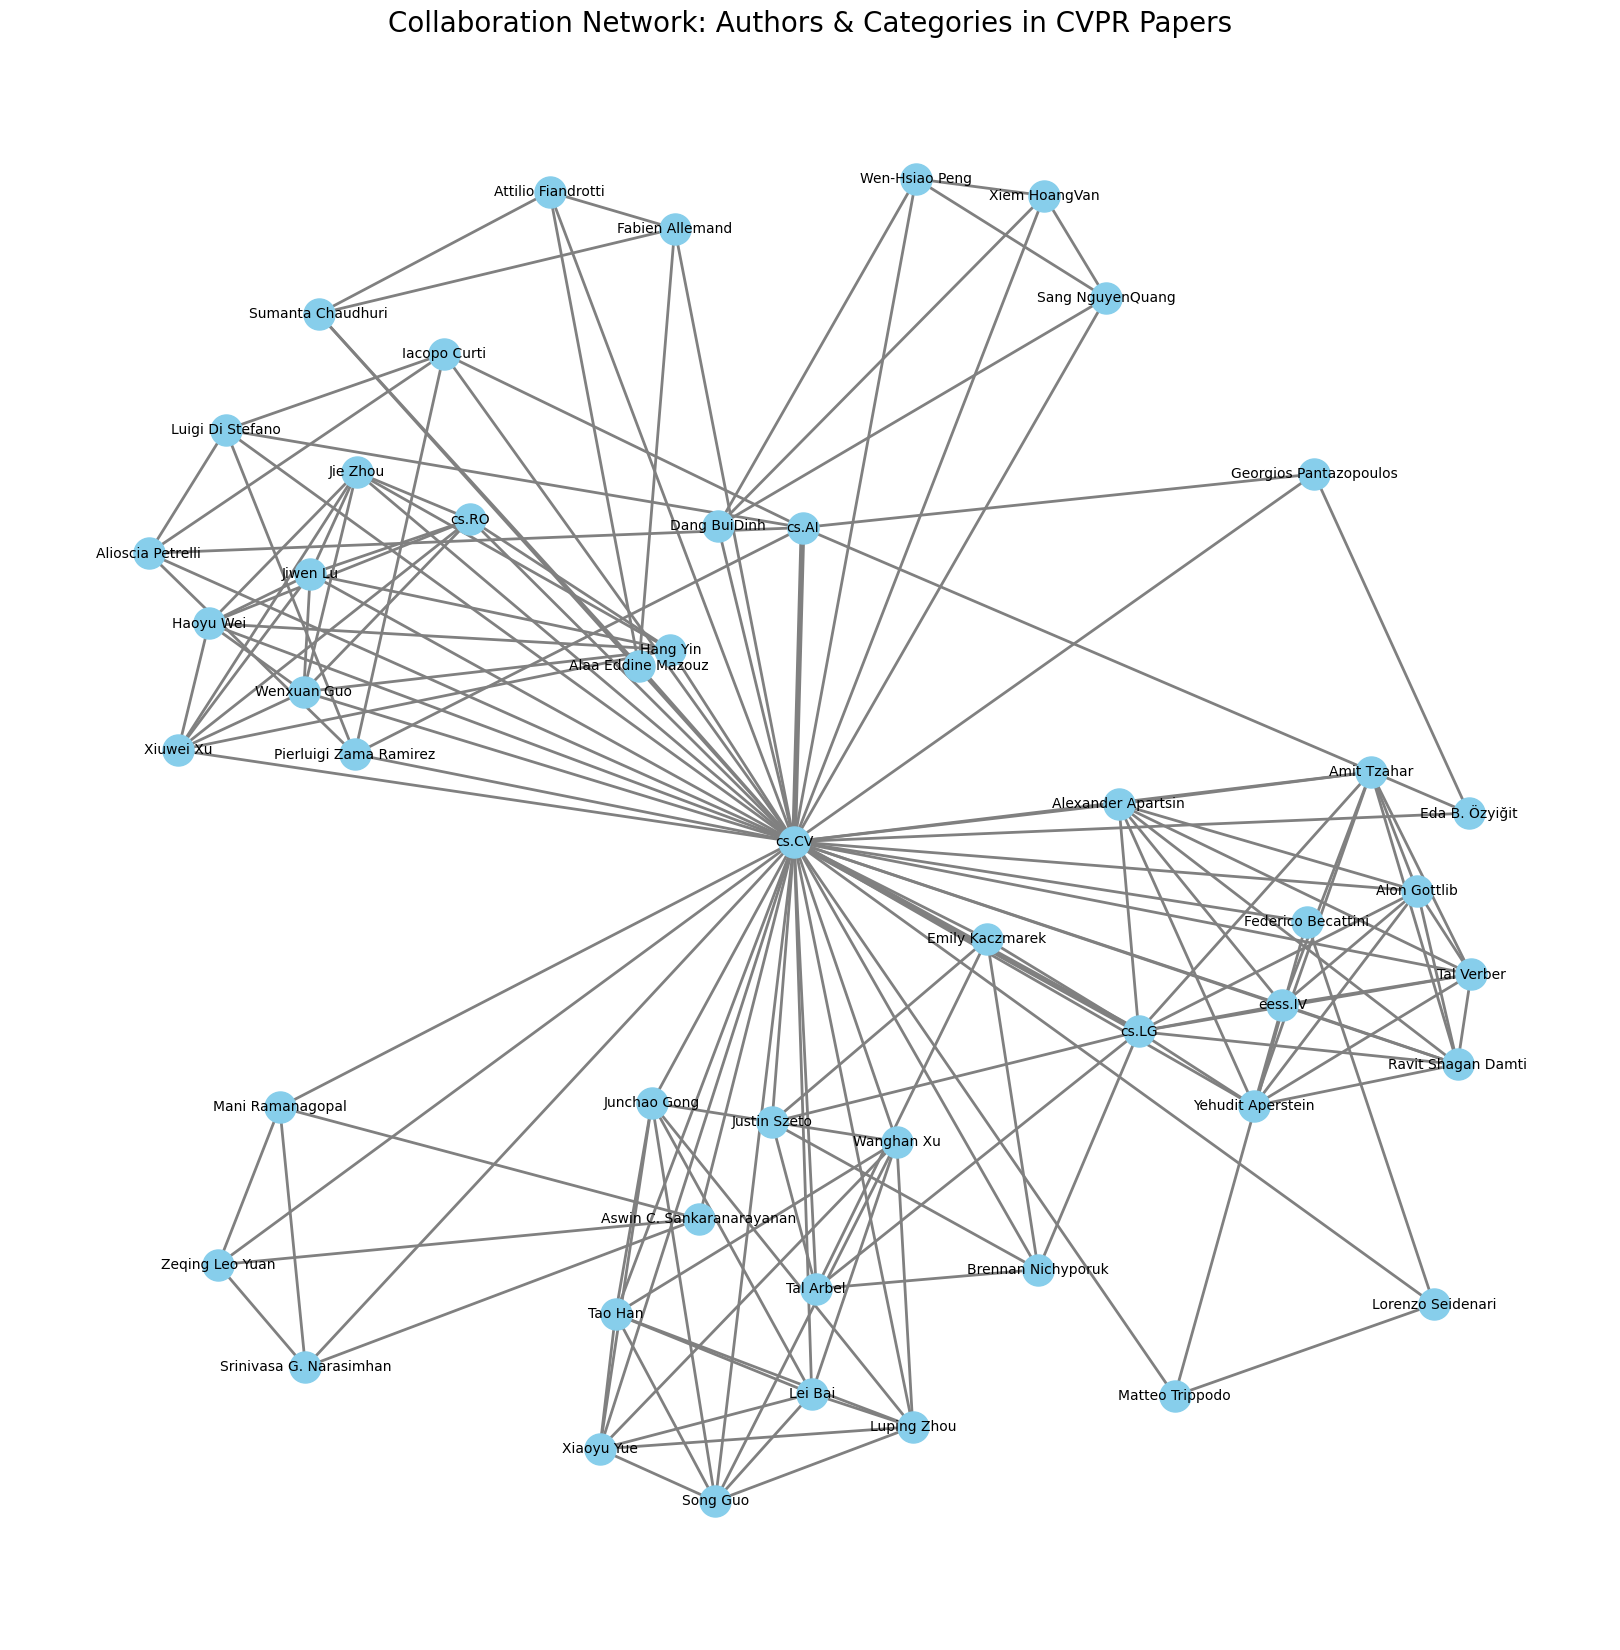

In [16]:
# GRAPH database visualization
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Collaboration Graph (authors + categories)
def build_collaboration_graph(papers):
    """Builds a graph including authors, primary categories, and cross-listed categories."""
    G = nx.Graph()
    for paper in papers:
        # Convert Author objects to string names if needed
        authors = paper.get('authors', [])
        authors_str = [a.name if hasattr(a, 'name') else str(a) for a in authors]

        # Combine all nodes for the paper
        nodes = []
        nodes.extend(authors_str)
        primary_cat = paper.get('primary_category')
        if primary_cat:
            nodes.append(primary_cat)
        categories = paper.get('categories', [])
        nodes.extend([str(c) for c in categories])

        # Remove duplicates
        nodes = list(set(nodes))

        if len(nodes) > 1:
            # Create edges between all pairs of nodes
            for node1, node2 in combinations(nodes, 2):
                if G.has_edge(node1, node2):
                    G[node1][node2]['weight'] += 1
                else:
                    G.add_edge(node1, node2, weight=1)
    return G

# Visualization
if __name__ == '__main__':
    print("Building collaboration graph (authors + categories)...")
    collaboration_graph = build_collaboration_graph(preprocessed_papers)
    print(f"Graph created with {collaboration_graph.number_of_nodes()} nodes and {collaboration_graph.number_of_edges()} edges.")

    if collaboration_graph.number_of_nodes() > 0:
        plt.figure(figsize=(16, 16))
        pos = nx.spring_layout(collaboration_graph, k=0.8, iterations=50)
        weights = [collaboration_graph[u][v]['weight'] for u, v in collaboration_graph.edges()]

        nx.draw(
            collaboration_graph, pos, with_labels=True, node_color='skyblue',
            node_size=500, width=[w * 2 for w in weights], font_size=10,
            font_color='black', edge_color='gray'
        )
        plt.title("Collaboration Network: Authors & Categories in CVPR Papers", size=20)
        plt.show()
    else:
        print("Graph is empty, cannot display.")
